# downstream performance: cost-related metrics

Data comes from Huawei FusionSolar and corresponds to one particular household

In [1]:
import pandas as pd
import numpy as np
import functions3Costs as ff
import matplotlib.pyplot as plt
import pickle 


#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

# Data and parameters

In [2]:
#data comes from fusionSolar, its inconsistencies are removed, data is processed 
#to the needed format and saved to file  
d=pickle.load(open('input_NE=34145276.pickle', "rb"))

In [3]:
d['data'].head(2)

,inputEnergy,ongridEnergy,loadEnergy,pvEnergy,chargeEnergy,dischargeEnergy,batterySOC,price,rawBatterySOC
2023-01-01 00:00:00,1.00,0.0,0.92,-0.05,0.0,0.0,0.0,0.00484,15.0
2023-01-01 01:00:00,0.42,0.0,0.42,0.00,0.0,0.0,0.0,0.00201,15.0


In [4]:
#parameters
#battery capacity is found from the household data; other parameters are free to change
d['params']

{'capacity': 10,
 'chargePower': 5,
 'roundTripEfficiency': 1,
 'minAllowedChargeLevel': 0.2,
 'depreciation': 0.01,
 'maxCyclesPerPeriod': 1,
 'mainFuse': 16,
 'percent': 0.02,
 'buyExtra': 0.0,
 'sellExtra': -0.0}

In [5]:
#realistic parameters to use for optimizer
#buying price formula: stockPrice*(1+taxPercent)+buyExtra
#selling price formula: stockPrice+sellExtra
par = d['params'].copy()
par['percent']=0.2  #tax for buying price
par['buyExtra']=0.07 #extra for buying price 
par['sellExtra'] = -0.01 #extra for selling price

#manual cost calculation used to find expected cost does not take into account battery
#depreciation. Thus to be consistent with the cost minimized by optimizer, we say to optimizer
#to forget about depreciation
par['depreciation'] = 0.0 

# optimized cost in  single-step and multi-steps schemas

In [6]:
#set oracle prediction
dd = d['data'].assign(predictedLoadEnergy=d['data']['loadEnergy'].values)

In [7]:
#single-step optimization schema optimizes battery for the provided interval
out24 = ff.optimize1step(dd[24:48],par) #single-step optimization for 24hours


#multi-step optimization schema does several optimization iterations:
#1. iteration - starts from timestamp1 and optimizes "period" values ahead 
#(eg start at 01:00 and for period=24 optimize 24 values ahead)

#stores charge/discharge values from 1. iteration for shortened interval defined by "shift" 
#(eg for shift=12 stores first 12 values from 01:00 to 12:00) 

#stores batteryLevel in the end of this shortened interval
#(eg batteryLevel at 12:00)

#2. iteration - shift focus to timestamp2 defined by "shift", use found BatteryLevel as initial value 
#and optimizes "period" values ahead 
#(eg for shift=12 start optimization at 13:00 and optimize next 24 hours ahead)

#store same data for shortened interval based on 2. run

#repeat

#last iteration - starting from certain timestamp optimize last 24 hours ahead

#collect all data regarding to charge/discharge
#(eg in our case it comes by pieces 12+12+...+12+24)

#multi-step optimization
#by one 24hour step - with these parameters does the same as single-step optimization 
#note that 1.iteration starts not at data.index[0] but at data[period:].index[0]
#this is becouse data[:period] may be used to predict load in the interval [period:][:period]
out24x1 = ff.optimizeNsteps(d['data'],par,'oracle',shift=24,iters=1,period=24) 

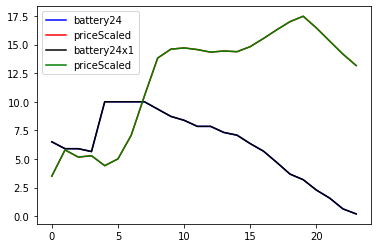

In [8]:
#compare results
ax = pd.DataFrame({'battery24':out24['batteryEnergy'],'priceScaled':100*dd['price'].values[24:48]}).plot(color=['b','r'])
pd.DataFrame({'battery24x1':out24x1['batteryEnergy'],'priceScaled':100*dd['price'].values[24:48]}).plot(ax=ax,color=['k','g']);
#results coincide as expected

In [9]:
#lets try 12x6x3 multi-step schema for oracle prediction
#here we do 3 optimization iterations for 12 hours ahead with 6hour shifts
#(eg optimization intervals are 01:00-12:00; 7:00-18:00; 13:00-00:00
#charge/discharge are collected by pieces 6+6+12)
#optimization starts at d['data'][12:][12:].index[0]
out12x6x3 = ff.optimizeNsteps(d['data'][12:],par,'oracle',shift=6,iters=3,period=12) 

In [10]:
#16x8x2 schema
#(eg optimization intervals are 01:00-16:00; 9:00-00:00
#charge/discharge are collected by pieces 8+16)
#optimization starts at d['data'][8:][16:].index[0]
out16x8x2 = ff.optimizeNsteps(d['data'][8:],par,'oracle',shift=8,iters=2,period=16) 

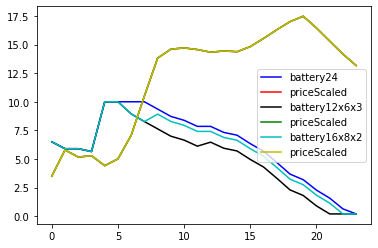

In [11]:
#visualize collected battery charge/discharge presented via batteryLevel
ax = pd.DataFrame({'battery24':out24x1['batteryEnergy'],'priceScaled':100*out24x1['input']['price'].values[:24]}).plot(color=['b','r'])
pd.DataFrame({'battery12x6x3':out12x6x3['batteryEnergy'],'priceScaled':100*out12x6x3['input']['price'].values[:24]}).plot(ax=ax,color=['k','g']);
pd.DataFrame({'battery16x8x2':out16x8x2['batteryEnergy'],'priceScaled':100*out16x8x2['input']['price'].values[:24]}).plot(ax=ax,color=['c','y']);
#optimized battery is sensitive to schema

optimization cost (opex) 1.727 Eur

expected cost (manually calculated)
cost 1.727 Euro (mae = 0.000)
input cost 1.727 Euro
ongrid gain 0.000 Euro


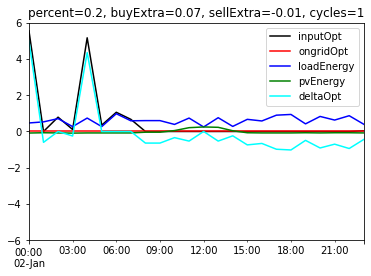

In [12]:
#since prediction=oracle, optimization cost=expected cost
print(f"optimization cost (opex) {out24['r']['objective']['value_components']['opex']:.3f} Eur\n\n\
expected cost (manually calculated)")
ff.vis2(ff.cost(out24x1))
#deltaOpt=charge-discharge
#we see that we charge when price is low (price curve is in previous image)
#and discharge when price is high to fully cover load and make input as small as possible
#optimization opex equals to expected cost - we expect this

In [13]:
print(ff.cost(out24)['message']) 
#should be the same

cost 1.727 Euro (mae = 0.000)
input cost 1.727 Euro
ongrid gain 0.000 Euro


cost 1.842 Euro (mae = 0.000)
input cost 1.842 Euro
ongrid gain 0.000 Euro


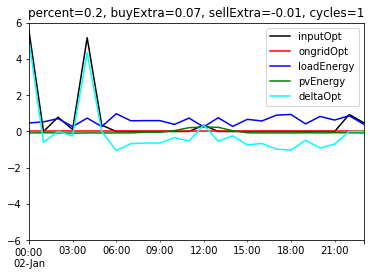

In [14]:
#for multi-step schemas the opex is undefined
ff.vis2(ff.cost(out12x6x3))

cost 1.836 Euro (mae = 0.000)
input cost 1.836 Euro
ongrid gain 0.000 Euro


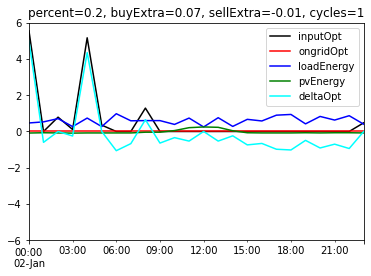

In [15]:
ff.vis2(ff.cost(out16x8x2))

# simulating cost massively

In [16]:
predType='oracle' #type of load prediction; supported oracle, const, const0, naive

#do many simulations (number=iterations) for schema periodXshiftXiters
#next simulation starts from next timestamp in dataset
#below is 5 simulations
#eg first simulation does 24h ahead optimization starting from 00:00, 
#second simulation does 24 ahead optimization starting from 01:00 etc 
qq24x1=ff.maeCostSim(d['data'],par,predType,shift=24,iters=1,iterations=5,period=24)

calculation time 22.336s        processing 5/5


In [17]:
qq12x6x3=ff.maeCostSim(d['data'][12:],par,predType,shift=6,iters=3,iterations=5,period=12)

calculation time 11.321s        processing 5/5


In [18]:
qq16x8x2=ff.maeCostSim(d['data'][8:],par,predType,shift=8,iters=2,iterations=5,period=16)

calculation time 22.024s        processing 5/5


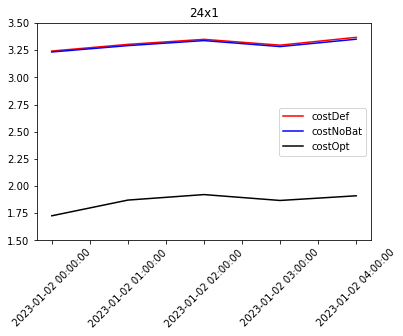

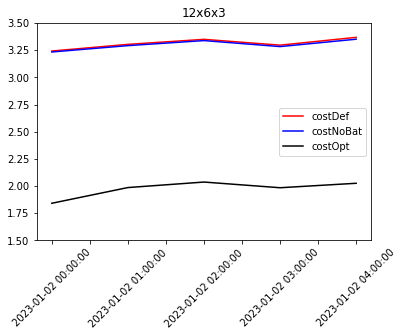

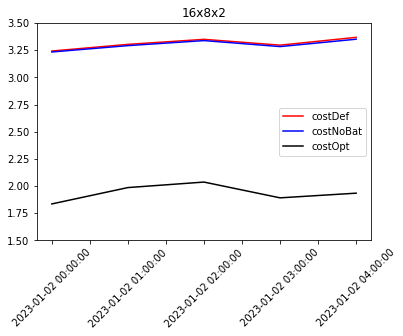

In [19]:
#visualize results of expected cost 
#costOpt - expected cost with battery optimized, 
#costDef - expected cost with battery as it was used by user,
#costNoBat - expected cost with no battery
def vis(qq, both=False,int1='',int2='',first=False):
    cols = {i:qq[i] for i in {i for i in qq if 'params' not in i}}
    df = pd.DataFrame(cols).set_index('idx').rename_axis(None)
    if first==True: df[['costDef','costNoBat','costOpt']].plot(color=['r','b','k'], title=int1,rot=45,ylim=(1.5,3.5))
    if both==True: df.plot(kind='scatter',x='mae', y='costOpt',title=int2)
    plt.show()
    return df

d1=vis(qq24x1,int1='24x1',first=True)
d2=vis(qq12x6x3,int1='12x6x3',first=True)
d3=vis(qq16x8x2,int1='16x8x2',first=True)
#it is expected that optimized cost is the lowest
#diffetent schemes results in different values of the optimized cost

In [20]:
#3 cost metrics
d1

,mae,costDef,costOpt,costNoBat
2023-01-02 00:00:00,0.0,3.242632,1.727196,3.233762
2023-01-02 01:00:00,0.0,3.303801,1.871551,3.292255
2023-01-02 02:00:00,0.0,3.350118,1.922204,3.338572
2023-01-02 03:00:00,0.0,3.296624,1.868058,3.283490
2023-01-02 04:00:00,0.0,3.368507,1.911066,3.351326


In [21]:
d2

,mae,costDef,costOpt,costNoBat
2023-01-02 00:00:00,0.0,3.242632,1.842276,3.233762
2023-01-02 01:00:00,0.0,3.303801,1.986803,3.292255
2023-01-02 02:00:00,0.0,3.350118,2.037456,3.338572
2023-01-02 03:00:00,0.0,3.296624,1.985174,3.283490
2023-01-02 04:00:00,0.0,3.368507,2.026146,3.351326


In [22]:
d3

,mae,costDef,costOpt,costNoBat
2023-01-02 00:00:00,0.0,3.242632,1.836183,3.233762
2023-01-02 01:00:00,0.0,3.303801,1.986631,3.292255
2023-01-02 02:00:00,0.0,3.350118,2.037283,3.338572
2023-01-02 03:00:00,0.0,3.296624,1.892196,3.283490
2023-01-02 04:00:00,0.0,3.368507,1.935205,3.351326


# summary

In [23]:
#three cost metrics
#eg oracle prediction and optimization schema 12x6x3
#optimization interval starting at d['data'][12:][12:].index[0]
qq=ff.maeCostSim(d['data'][12:],par,'oracle',shift=6,iters=3,iterations=1,period=12)

calculation time 2.672s         processing 1/1


In [24]:
vis(qq)

,mae,costDef,costOpt,costNoBat
2023-01-02 00:00:00,0.0,3.242632,1.842276,3.233762


In [25]:
#three cost metrics for other prediction type
#let it be const0 ie load=const=0 for whole optimization interval
vis(ff.maeCostSim(d['data'][12:],par,'const0',shift=6,iters=3,iterations=1,period=12))
#costDef and costNoBat are expected to be the same

calculation time 3.296s         processing 1/1


,mae,costDef,costOpt,costNoBat
2023-01-02 00:00:00,0.604444,3.242632,2.43451,3.233762
